In [1]:
import matplotlib.pyplot as plt
import numpy as np
from CourantFunctions import CourantFunctions as cf
import MathHelper as mh
import pandas as pd
import math
import time
import imageio
import os
from scipy import integrate
plt.rcParams['figure.figsize'] = [25, 10]
plt.rcParams['legend.fontsize'] = 30

#input data
l = 0.01
N = 256
T=75*math.pow(10,-7)
#T=12*math.pow(12,-7)
step = l/N
#gamma and beta
gamma = 0.5
beta = 0.25
#густина
rho=7500#ok
#механічне напруження
sigma=0
#коефіцієнт теплового розширення
alpha=0.000002#ok
#теплові внутрішні об'ємні сили
w=0
#механічні внутрішні об'ємні сили
f=0
#модуль Юнга
c=139000000000#ok
#коефіцієнт п'єзоелектрики
E=15.1#ok
E=0
#електрична індукція
D=0
#коефіцієнт діелектричної проникливості
g=0.00000000646#ok
#задане значення теплового потоку в точці L
def hShtrih(t):#ok
    return 0
#коефіцієнт теплопровідності
Lambda=1.1#ok
#коефіцієнт піроелектрики
pSmall=0.00027#ok 
#почтакове значення тепла T
Tzero = 1/298
#коефіцієнт електропровідності
z = 5*math.pow(10,-12)#ok
#питома теплоємності
cE = 350#ok
#коеф вязкості
a = 4#ok

def sigmaShtrih(t):#ok
    if t<=5*math.pow(10,-7):
        return 5*math.pow(10,6)
    else:
        return 0
    
def JShtrih(t):#ok
    #if t<=5*math.pow(10,-7):
      #  return 100
    #else:
    return 0
#швидкість хвилі
wave_speed = math.sqrt(c/rho)
T_for_1_cycle = l/wave_speed
# T_for_1_cycle = 23.85*math.pow(10,-7)
print(T_for_1_cycle)

2.3228610490594163e-06


In [2]:
#ФУНКЦІЇ куранта
fi = []
fiDerivatives = []
xi = [0]
for i in range(1,N+1):
    xi.append(xi[i-1]+step)

for i in range(0,N+1):
    new_function = cf(i,N,l)
    fi.append(new_function.fi)
    fiDerivatives.append(new_function.fiDerivative)
    

In [3]:
#формування початкових матриць
def FillFiAndDerMatrix(koeficient):
    CMatrix = list(np.zeros((N+1,3)))
    CMatrix[0][0] = 0
    CMatrix[0][1] = mh.IntegrateGauss(lambda x: (koeficient*fi[0](x)*fiDerivatives[0](x)),xi[0],xi[1])
    CMatrix[0][2] = mh.IntegrateGauss(lambda x: (koeficient*fi[0](x)*fiDerivatives[1](x)),xi[0],xi[1])#так само
    
    for i in range(1,N):
        CMatrix[i][0] = mh.IntegrateGauss(lambda x: (koeficient*fi[i](x)*fiDerivatives[i-1](x)),xi[i-1],xi[i])
        CMatrix[i][1] = mh.IntegrateGauss(lambda x: (koeficient*fi[i](x)*fiDerivatives[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] += mh.IntegrateGauss(lambda x: (koeficient*fi[i](x)*fiDerivatives[i](x)),xi[i],xi[i+1])
        CMatrix[i][2] = mh.IntegrateGauss(lambda x: (koeficient*fi[i](x)*fiDerivatives[i+1](x)),xi[i],xi[i+1])
    
    CMatrix[N][0] = mh.IntegrateGauss(lambda x: (koeficient*fi[N](x)*fiDerivatives[N-1](x)),xi[N-1],xi[N])#міняю індекси в фі і фі дер
    CMatrix[N][1] = mh.IntegrateGauss(lambda x: (koeficient*fi[N](x)*fiDerivatives[N](x)),xi[N-1],xi[N])
    CMatrix[N][2] = 0
    
    CMatrixNew = list(np.zeros((N+1,N+1)))
    for i in range(0,N+1):
        CMatrixNew[i][i] = CMatrix[i][1]
        if i > 0:
            CMatrixNew[i][i-1] = CMatrix[i][0]
        if i < N:
            CMatrixNew[i][i+1] = CMatrix[i][2]
            
    return np.array(CMatrixNew)
    
def FillMMatrix(koeficient):
    CMatrix = list(np.zeros((N+1,3)))
    CMatrix[0][0] = 0
    CMatrix[0][1] = mh.IntegrateGauss(lambda x: (koeficient*fi[0](x)*fi[0](x)),xi[0],xi[1])
    CMatrix[0][2] = mh.IntegrateGauss(lambda x: (koeficient*fi[0](x)*fi[1](x)),xi[0],xi[1])
    
    for i in range(1,N):
        CMatrix[i][0] = mh.IntegrateGauss(lambda x: (koeficient*fi[i-1](x)*fi[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] = mh.IntegrateGauss(lambda x: (koeficient*fi[i](x)*fi[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] += mh.IntegrateGauss(lambda x: (koeficient*fi[i](x)*fi[i](x)),xi[i],xi[i+1])
        CMatrix[i][2] = mh.IntegrateGauss(lambda x: (koeficient*fi[i](x)*fi[i+1](x)),xi[i],xi[i+1])
    
    CMatrix[N][0] = mh.IntegrateGauss(lambda x: (koeficient*fi[N-1](x)*fi[N](x)),xi[N-1],xi[N])
    CMatrix[N][1] = mh.IntegrateGauss(lambda x: (koeficient*fi[N](x)*fi[N](x)),xi[N-1],xi[N])
    CMatrix[N][2] = 0
    
    CMatrixNew = list(np.zeros((N+1,N+1)))
    for i in range(0,N+1):
        CMatrixNew[i][i] = CMatrix[i][1]
        if i > 0:
            CMatrixNew[i][i-1] = CMatrix[i][0]
        if i < N:
            CMatrixNew[i][i+1] = CMatrix[i][2]
        
    return np.array(CMatrixNew)
###
def FillAMatrix(koeficient):
    CMatrix = list(np.zeros((N+1,3)))
    CMatrix[0][0] = 0
    CMatrix[0][1] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[0](x)*fiDerivatives[0](x)),xi[0],xi[1])
    CMatrix[0][2] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[0](x)*fiDerivatives[1](x)),xi[0],xi[1])
    
    for i in range(1,N):
        CMatrix[i][0] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[i-1](x)*fiDerivatives[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[i](x)*fiDerivatives[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] += mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[i](x)*fiDerivatives[i](x)),xi[i],xi[i+1])
        CMatrix[i][2] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[i](x)*fiDerivatives[i+1](x)),xi[i],xi[i+1])
    
    CMatrix[N][0] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[N-1](x)*fiDerivatives[N](x)),xi[N-1],xi[N])
    CMatrix[N][1] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[N](x)*fiDerivatives[N](x)),xi[N-1],xi[N])
    CMatrix[N][2] = 0
    
    CMatrixNew = list(np.zeros((N+1,N+1)))
    for i in range(0,N+1):
        CMatrixNew[i][i] = CMatrix[i][1]
        if i > 0:
            CMatrixNew[i][i-1] = CMatrix[i][0]
        if i < N:
            CMatrixNew[i][i+1] = CMatrix[i][2]
        
    return np.array(CMatrixNew)
###
def FillEMatrix(koeficient):
    CMatrix = list(np.zeros((N+1,3)))
    CMatrix[0][0] = 0
    CMatrix[0][1] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[0](x)*fiDerivatives[0](x)),xi[0],xi[1])
    CMatrix[0][2] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[0](x)*fiDerivatives[1](x)),xi[0],xi[1])
    
    for i in range(1,N):
        CMatrix[i][0] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[i-1](x)*fiDerivatives[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[i](x)*fiDerivatives[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] += mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[i](x)*fiDerivatives[i](x)),xi[i],xi[i+1])
        CMatrix[i][2] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[i](x)*fiDerivatives[i+1](x)),xi[i],xi[i+1])
    
    CMatrix[N][0] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[N-1](x)*fiDerivatives[N](x)),xi[N-1],xi[N])
    CMatrix[N][1] = mh.IntegrateGauss(lambda x: (koeficient*fiDerivatives[N](x)*fiDerivatives[N](x)),xi[N-1],xi[N])
    CMatrix[N][2] = 0
    
    CMatrixNew = list(np.zeros((N+1,N+1)))
    for i in range(0,N+1):
        CMatrixNew[i][i] = CMatrix[i][1]
        if i > 0:
            CMatrixNew[i][i-1] = CMatrix[i][0]
        if i < N:
            CMatrixNew[i][i+1] = CMatrix[i][2]
    ###-1 multiplication
    ResMatrix = list((-1)*np.array(CMatrixNew))
        
    return np.array(ResMatrix)
###
def FillSMatrix(koeficient,pytoma,start_temp):#rho = 7500, cE = 350, Tzero = 293
    CMatrix = list(np.zeros((N+1,3)))
    CMatrix[0][0] = 0
    CMatrix[0][1] = mh.IntegrateGauss(lambda x: (koeficient*pytoma*start_temp*fi[0](x)*fi[0](x)),xi[0],xi[1])
    CMatrix[0][2] = mh.IntegrateGauss(lambda x: (koeficient*pytoma*start_temp*fi[0](x)*fi[1](x)),xi[0],xi[1])
    
    for i in range(1,N):
        CMatrix[i][0] = mh.IntegrateGauss(lambda x: (koeficient*pytoma*start_temp*fi[i-1](x)*fi[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] = mh.IntegrateGauss(lambda x: (koeficient*pytoma*start_temp*fi[i](x)*fi[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] += mh.IntegrateGauss(lambda x: (koeficient*pytoma*start_temp*fi[i](x)*fi[i](x)),xi[i],xi[i+1])
        CMatrix[i][2] = mh.IntegrateGauss(lambda x: (koeficient*pytoma*start_temp*fi[i](x)*fi[i+1](x)),xi[i],xi[i+1])
    
    CMatrix[N][0] = mh.IntegrateGauss(lambda x: (koeficient*pytoma*start_temp*fi[N-1](x)*fi[N](x)),xi[N-1],xi[N])
    CMatrix[N][1] = mh.IntegrateGauss(lambda x: (koeficient*pytoma*start_temp*fi[N](x)*fi[N](x)),xi[N-1],xi[N])
    CMatrix[N][2] = 0
    
    CMatrixNew = list(np.zeros((N+1,N+1)))
    for i in range(0,N+1):
        CMatrixNew[i][i] = CMatrix[i][1]
        if i > 0:
            CMatrixNew[i][i-1] = CMatrix[i][0]
        if i < N:
            CMatrixNew[i][i+1] = CMatrix[i][2]
        
    return np.array(CMatrixNew)
###
def FillYMatrix(c,alpha):
    CMatrix = list(np.zeros((N+1,3)))
    CMatrix[0][0] = 0
    CMatrix[0][1] = mh.IntegrateGauss(lambda x: (c*alpha*fi[0](x)*fiDerivatives[0](x)),xi[0],xi[1])
    CMatrix[0][2] = mh.IntegrateGauss(lambda x: (c*alpha*fi[0](x)*fiDerivatives[1](x)),xi[0],xi[1])
    
    for i in range(1,N):
        CMatrix[i][0] = mh.IntegrateGauss(lambda x: (c*alpha*fi[i](x)*fiDerivatives[i-1](x)),xi[i-1],xi[i])
        CMatrix[i][1] = mh.IntegrateGauss(lambda x: (c*alpha*fi[i](x)*fiDerivatives[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] += mh.IntegrateGauss(lambda x: (c*alpha*fi[i](x)*fiDerivatives[i](x)),xi[i],xi[i+1])
        CMatrix[i][2] = mh.IntegrateGauss(lambda x: (c*alpha*fi[i](x)*fiDerivatives[i+1](x)),xi[i],xi[i+1])
    
    CMatrix[N][0] = mh.IntegrateGauss(lambda x: (c*alpha*fi[N](x)*fiDerivatives[N-1](x)),xi[N-1],xi[N])
    CMatrix[N][1] = mh.IntegrateGauss(lambda x: (c*alpha*fi[N](x)*fiDerivatives[N](x)),xi[N-1],xi[N])
    CMatrix[N][2] = 0
    
    CMatrixNew = list(np.zeros((N+1,N+1)))
    for i in range(0,N+1):
        CMatrixNew[i][i] = CMatrix[i][1]
        if i > 0:
            CMatrixNew[i][i-1] = CMatrix[i][0]
        if i < N:
            CMatrixNew[i][i+1] = CMatrix[i][2]
        
    return np.array(CMatrixNew)
###
def FillPMatrix(p):
    CMatrix = list(np.zeros((N+1,3)))
    CMatrix[0][0] = 0
    CMatrix[0][1] = mh.IntegrateGauss(lambda x: (p*fi[0](x)*fiDerivatives[0](x)),xi[0],xi[1])
    CMatrix[0][2] = mh.IntegrateGauss(lambda x: (p*fi[1](x)*fiDerivatives[0](x)),xi[0],xi[1])#так само
    
    for i in range(1,N):
        CMatrix[i][0] = mh.IntegrateGauss(lambda x: (p*fi[i](x)*fiDerivatives[i-1](x)),xi[i-1],xi[i])
        CMatrix[i][1] = mh.IntegrateGauss(lambda x: (p*fi[i](x)*fiDerivatives[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] += mh.IntegrateGauss(lambda x: (p*fi[i](x)*fiDerivatives[i](x)),xi[i],xi[i+1])
        CMatrix[i][2] = mh.IntegrateGauss(lambda x: (p*fi[i](x)*fiDerivatives[i+1](x)),xi[i],xi[i+1])
    
    CMatrix[N][0] = mh.IntegrateGauss(lambda x: (p*fi[N-1](x)*fiDerivatives[N](x)),xi[N-1],xi[N])#міняю індекси в фі і фі дер
    CMatrix[N][1] = mh.IntegrateGauss(lambda x: (p*fi[N](x)*fiDerivatives[N](x)),xi[N-1],xi[N])
    CMatrix[N][2] = 0
    
    CMatrixNew = list(np.zeros((N+1,N+1)))
    for i in range(0,N+1):
        CMatrixNew[i][i] = CMatrix[i][1]
        if i > 0:
            CMatrixNew[i][i-1] = CMatrix[i][0]
        if i < N:
            CMatrixNew[i][i+1] = CMatrix[i][2]
            
    ###-1 multiplication
    ResMatrix = list((-1)*np.array(CMatrixNew))
        
    return np.array(ResMatrix)
###
def FillKMatrix(koeficient,start_temp):
    CMatrix = list(np.zeros((N+1,3)))
    CMatrix[0][0] = 0
    CMatrix[0][1] = mh.IntegrateGauss(lambda x: (koeficient*start_temp*fiDerivatives[0](x)*fiDerivatives[0](x)),xi[0],xi[1])
    CMatrix[0][2] = mh.IntegrateGauss(lambda x: (koeficient*start_temp*fiDerivatives[0](x)*fiDerivatives[1](x)),xi[0],xi[1])
    
    for i in range(1,N):
        CMatrix[i][0] = mh.IntegrateGauss(lambda x: (koeficient*start_temp*fiDerivatives[i-1](x)*fiDerivatives[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] = mh.IntegrateGauss(lambda x: (koeficient*start_temp*fiDerivatives[i](x)*fiDerivatives[i](x)),xi[i-1],xi[i])
        CMatrix[i][1] += mh.IntegrateGauss(lambda x: (koeficient*start_temp*fiDerivatives[i](x)*fiDerivatives[i](x)),xi[i],xi[i+1])
        CMatrix[i][2] = mh.IntegrateGauss(lambda x: (koeficient*start_temp*fiDerivatives[i](x)*fiDerivatives[i+1](x)),xi[i],xi[i+1])
    
    CMatrix[N][0] = mh.IntegrateGauss(lambda x: (koeficient*start_temp*fiDerivatives[N-1](x)*fiDerivatives[N](x)),xi[N-1],xi[N])
    CMatrix[N][1] = mh.IntegrateGauss(lambda x: (koeficient*start_temp*fiDerivatives[N](x)*fiDerivatives[N](x)),xi[N-1],xi[N])
    CMatrix[N][2] = 0
    
    CMatrixNew = list(np.zeros((N+1,N+1)))
    for i in range(0,N+1):
        CMatrixNew[i][i] = CMatrix[i][1]
        if i > 0:
            CMatrixNew[i][i-1] = CMatrix[i][0]
        if i < N:
            CMatrixNew[i][i+1] = CMatrix[i][2]
        
    return np.array(CMatrixNew)

In [4]:
start_time = time.time()
MMatrix = FillMMatrix(rho)
AMatrix = FillAMatrix(a)
EMatrix = FillEMatrix(E)
ZMatrix = FillAMatrix(z)
SMatrix = FillMMatrix(rho*cE*Tzero)
CMatrix = FillAMatrix(c)
YMatrix = FillFiAndDerMatrix(c*alpha)
GMatrix = FillAMatrix(g)
PMatrix = (-1)*FillFiAndDerMatrix(pSmall)
KMatrix = FillKMatrix(Lambda,Tzero)

In [5]:
#формування векторів початкових умов правої частини слар
u0 = np.zeros((N+1))
udot0 = np.zeros((N+1))
p0 = np.zeros((N+1))
thetta0 = np.zeros((N+1))  
d0 = np.zeros((3*(N+1)))
a0 = np.zeros((3*(N+1)))
v0 = np.zeros((3*(N+1)))

In [6]:
Nt = 1000
dt=T/Nt
t = 0
#constructing main matrix
MainMatrix = list(np.zeros((3*(N+1),3*(N+1))))
for i in range(0,N+1):
    for j in range(0,N+1):
        #first row
        MainMatrix[i][j] = MMatrix[i][j] + (dt*gamma)*AMatrix[i][j] + 0.5*dt*dt*beta*CMatrix[i][j]
        MainMatrix[i][j+N+1] = (-1)*dt*gamma*EMatrix.transpose()[i][j]
        MainMatrix[i][j+2*(N+1)] = (-1)*dt*gamma*YMatrix.transpose()[i][j]
        #second row
        MainMatrix[i+N+1][j] = dt*gamma*EMatrix[i][j]
        MainMatrix[i+N+1][j+N+1] = GMatrix[i][j]+(dt*gamma*ZMatrix[i][j])
        MainMatrix[i+N+1][j+2*(N+1)] = PMatrix.transpose()[i][j]
        #third row
        MainMatrix[i+2*(N+1)][j] = dt*gamma*YMatrix[i][j]
        MainMatrix[i+2*(N+1)][j+N+1] = PMatrix[i][j]
        MainMatrix[i+2*(N+1)][j+2*(N+1)] = (SMatrix[i][j]+(dt*gamma)*KMatrix[i][j])#ok
        

MainMatrix[0][0] = pow(10,20)
MainMatrix[N+1][N+1] = pow(10,20)
MainMatrix[2*N+2][2*N+2] = pow(10,20)
#print(pd.DataFrame(MainMatrix))

In [7]:
#M, C and K matrices are constant throughout the flow of program, here we calculate them
equationMMatrix = list(np.zeros((3*(N+1),3*(N+1))))
equationCMatrix = list(np.zeros((3*(N+1),3*(N+1))))
equationKMatrix = list(np.zeros((3*(N+1),3*(N+1))))
for i in range(0,N+1):
    for j in range(0,N+1):
        #first row
        equationMMatrix[i][j] = MMatrix[i][j]
        equationMMatrix[i][j+N+1] = 0
        equationMMatrix[i][j+2*(N+1)] = 0
        #second row
        equationMMatrix[i+N+1][j] = 0
        equationMMatrix[i+N+1][j+N+1] = 0
        equationMMatrix[i+N+1][j+2*(N+1)] = 0
        #third row
        equationMMatrix[i+2*(N+1)][j] = 0
        equationMMatrix[i+2*(N+1)][j+N+1] = 0
        equationMMatrix[i+2*(N+1)][j+2*(N+1)] = 0
        
    
for i in range(0,N+1):
    for j in range(0,N+1):
        #first row
        equationCMatrix[i][j] = AMatrix[i][j]
        equationCMatrix[i][j+N+1] = 0
        equationCMatrix[i][j+2*(N+1)] = 0
        #second row
        equationCMatrix[i+N+1][j] = EMatrix[i][j]
        equationCMatrix[i+N+1][j+N+1] = GMatrix[i][j]
        equationCMatrix[i+N+1][j+2*(N+1)] = PMatrix.transpose()[i][j]
        #third row
        equationCMatrix[i+2*(N+1)][j] = YMatrix[i][j]
        equationCMatrix[i+2*(N+1)][j+N+1] = PMatrix[i][j]
        equationCMatrix[i+2*(N+1)][j+2*(N+1)] = SMatrix[i][j]
        

for i in range(0,N+1):
    for j in range(0,N+1):
        #first row
        equationKMatrix[i][j] = CMatrix[i][j]
        equationKMatrix[i][j+N+1] = (-1)*EMatrix.transpose()[i][j]
        equationKMatrix[i][j+2*(N+1)] = (-1)*YMatrix.transpose()[i][j]
        #second row
        equationKMatrix[i+N+1][j] = 0
        equationKMatrix[i+N+1][j+N+1] = ZMatrix[i][j]
        equationKMatrix[i+N+1][j+2*(N+1)] = 0
        #third row
        equationKMatrix[i+2*(N+1)][j] = 0
        equationKMatrix[i+2*(N+1)][j+N+1] = 0
        equationKMatrix[i+2*(N+1)][j+2*(N+1)] = KMatrix[i][j]

# print(pd.DataFrame(equationKMatrix))

equationMMatrix[0][0] = pow(10,20)
equationMMatrix[N+1][N+1] = pow(10,20)
equationMMatrix[2*N+2][2*N+2] = pow(10,20)

equationCMatrix[0][0] = pow(10,20)
equationCMatrix[N+1][N+1] = pow(10,20)
equationCMatrix[2*N+2][2*N+2] = pow(10,20)

equationKMatrix[0][0] = pow(10,20)
equationKMatrix[N+1][N+1] = pow(10,20)
equationKMatrix[2*N+2][2*N+2] = pow(10,20)


In [8]:
#розвязок однокрокової рекурентної схеми
t_lim = 23.85*math.pow(10,-7)
LJplusHalf = np.zeros((N+1))
RJplusHalf = np.zeros((N+1))
FJplusHalf = np.zeros((N+1))
result = np.zeros(3*(N+1))
thettaP_energy = np.zeros((Nt+1))
potential_energy = np.zeros((Nt+1))
kinetic_energy = np.zeros((Nt+1))
electric_energy = np.zeros((Nt+1))
heat_energy = np.zeros((Nt+1))
mech_loss = np.zeros((Nt+1))
electric_loss = np.zeros((Nt+1))
heat_loss = np.zeros((Nt+1))
right_part = np.zeros((Nt+1))
right_part2 = np.zeros((Nt+1))
time_iter_count = 0
while t<=T:
    #предиктори
    dNextPred = np.array(d0) + dt*np.array(v0) + ((dt*dt)/2)*(1-2*beta)*np.array(a0)
    vNextPred = np.array(v0) + (1-gamma)*dt*np.array(a0)
    
    #формуємо вектори L, R та F за лінійними функціоналами
    for i in range(0,N+1):
        LJplusHalf[i] = sigmaShtrih(t+dt)*fi[i](l)
        RJplusHalf[i] = JShtrih(t+dt)*fi[i](l)
        FJplusHalf[i] = (-hShtrih(t+dt)*fi[i](l))*Tzero
    
    fVec = list(LJplusHalf) + list(RJplusHalf) + list(FJplusHalf)
    
    leftPartMatrixOfEquation = np.array(equationMMatrix) + gamma*dt*np.array(equationCMatrix) + beta*dt*dt*np.array(equationKMatrix)
    rightPartMatrixOfEquation = np.array(fVec) - np.array(equationCMatrix).dot(vNextPred)-np.array(equationKMatrix).dot(dNextPred)
    
    aNext = np.linalg.solve(leftPartMatrixOfEquation, rightPartMatrixOfEquation)
    dNext = dNextPred + beta*dt*dt*aNext
    vNext = vNextPred + gamma*dt*aNext
    
    a0 = aNext
    d0 = dNext
    v0 = vNext
    
    u0 = d0[:(N+1)]
    p0 = d0[(N+1):2*(N+1)]
    thetta0 = d0[2*(N+1):]
    
    udot0 = v0[:(N+1)]
    
    if t>t_lim:
        break
        
    t+=dt
    time_iter_count+=1
    
end_time = time.time()

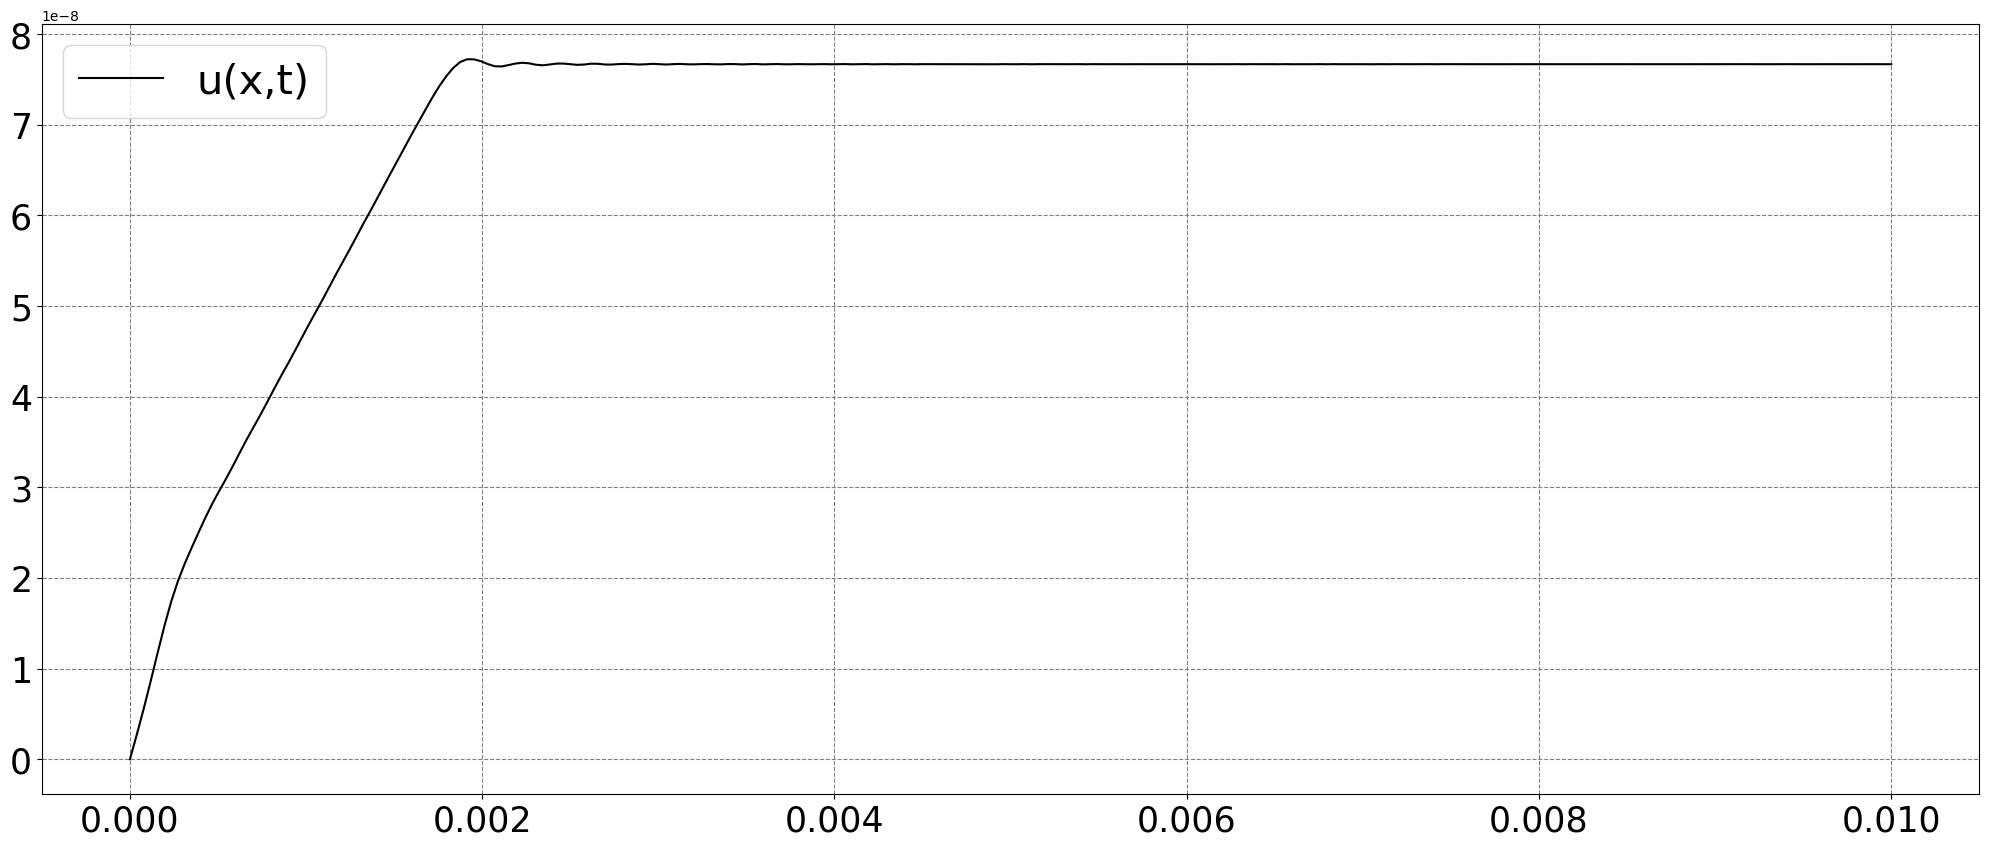

In [9]:
plt.plot(xi,u0,label = 'u(x,t)',color = 'black')
plt.legend()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.grid(color = 'grey', linestyle = '--')
plt.show()

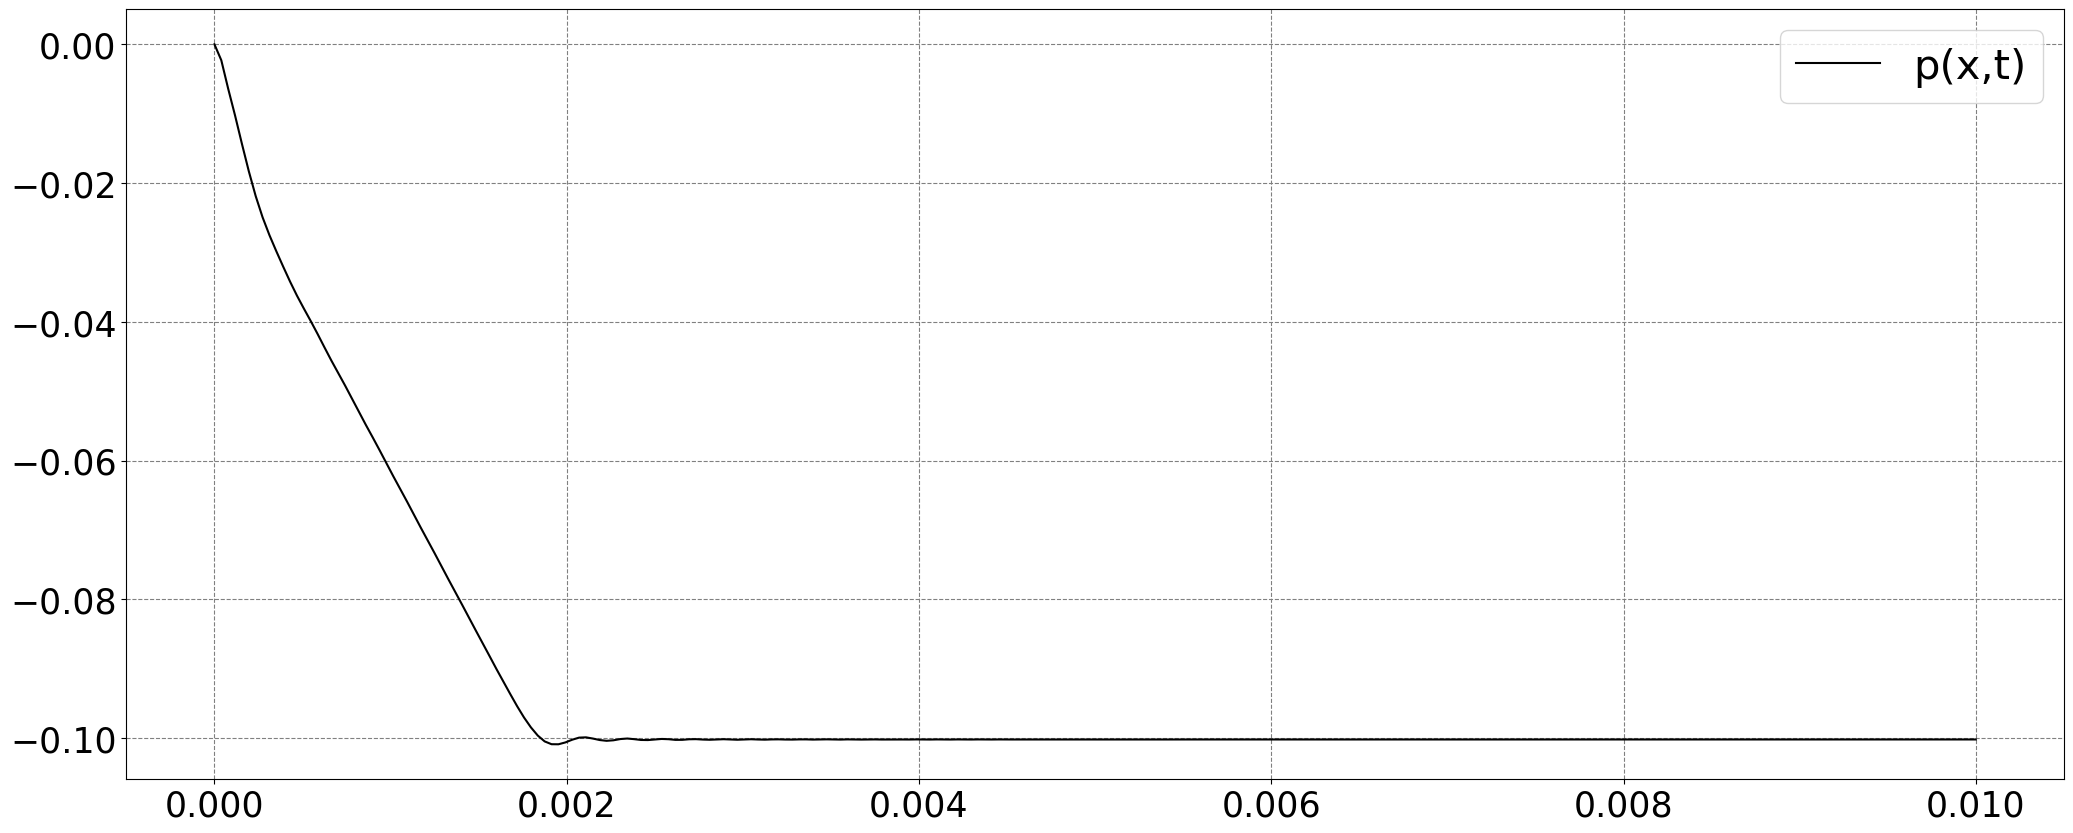

In [10]:
plt.plot(xi,p0,label = 'p(x,t)',color = 'black')
plt.legend()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.grid(color = 'grey', linestyle = '--')
plt.show()

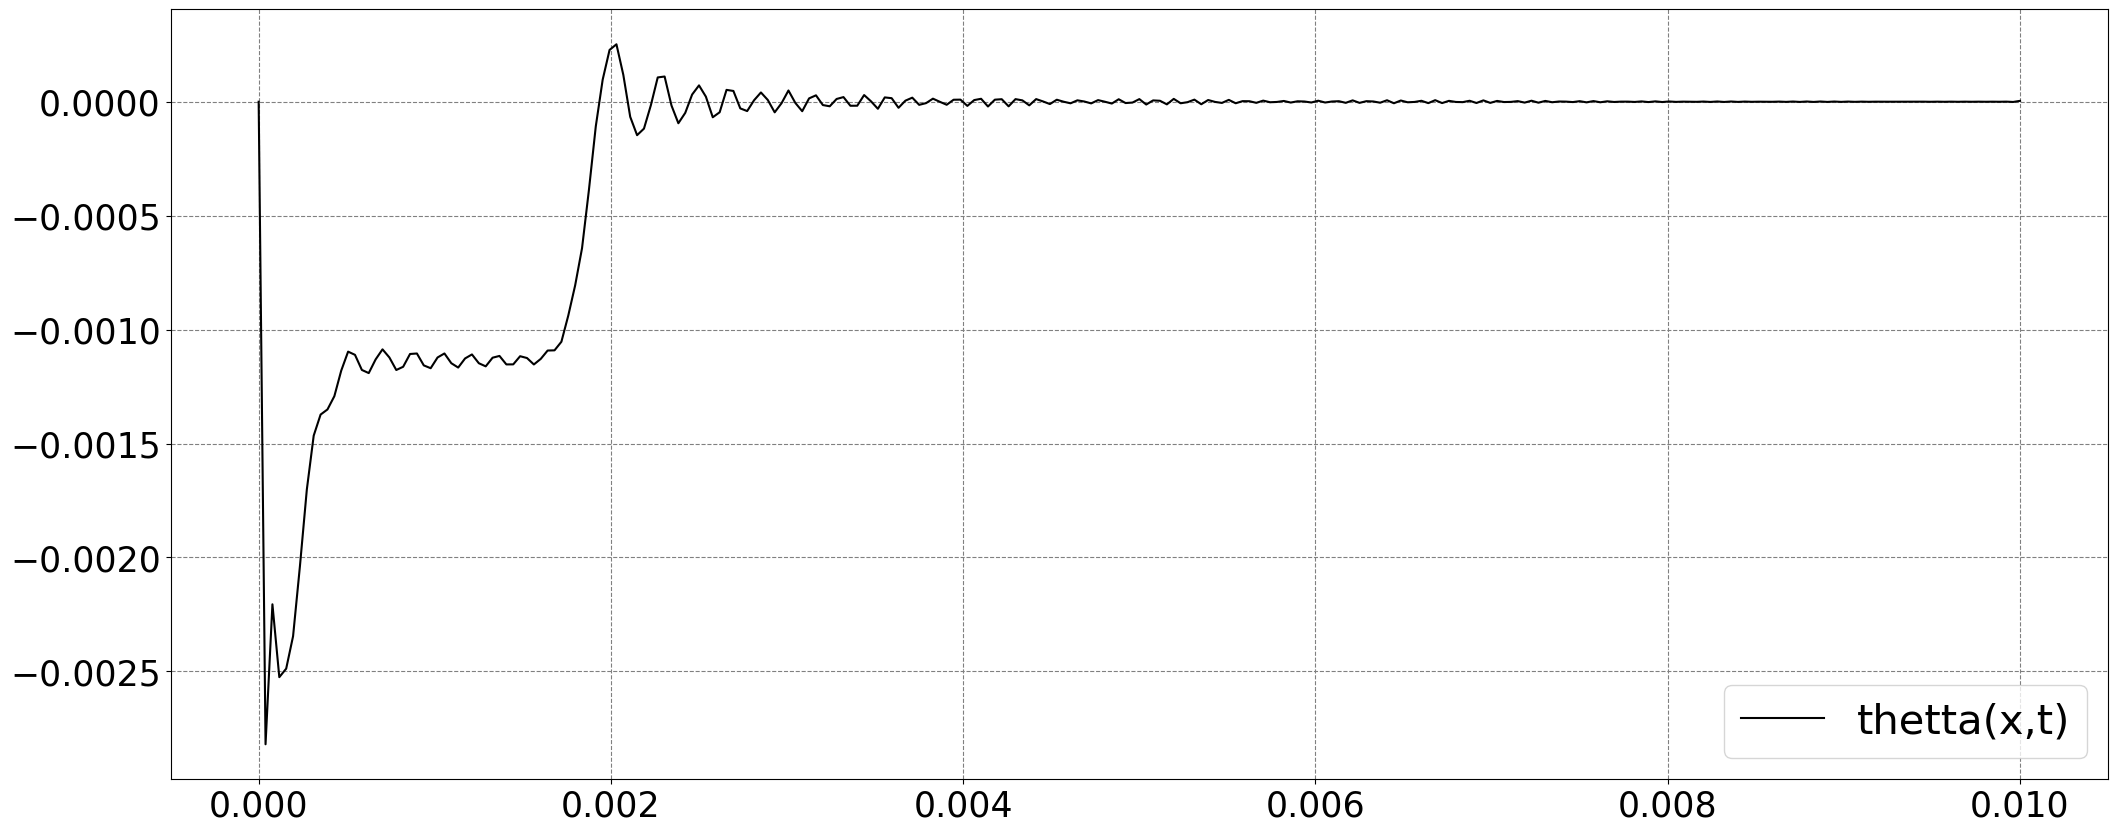

In [11]:
plt.plot(xi,thetta0,label = 'thetta(x,t)',color = 'black')
plt.legend()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.grid(color = 'grey', linestyle = '--')
plt.show()

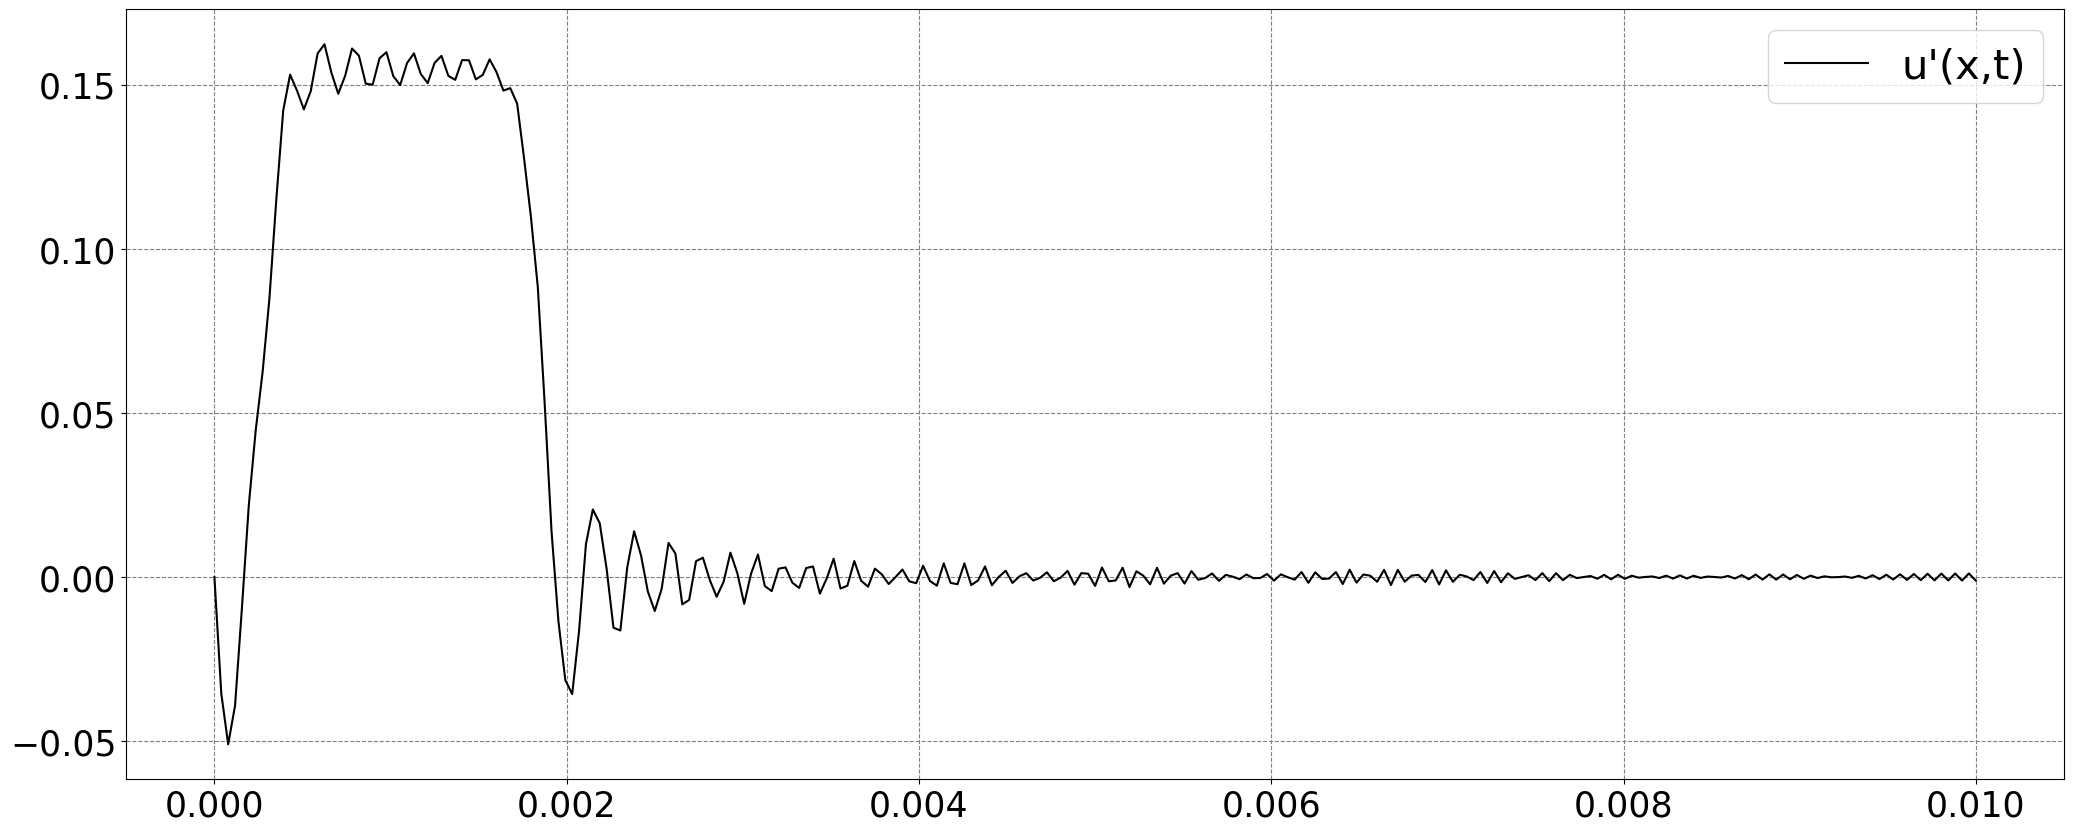

In [12]:
plt.plot(xi,udot0,label = "u'(x,t)",color = 'black')
plt.legend()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.grid(color = 'grey', linestyle = '--')
plt.show()